###SmartWatch Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe

link = 'https://drive.google.com/file/d/1A46FlopzRBsaLeq0-NawM5xRpcpxQ2I2/view?usp=sharing'
name = 'user_sensor_data.csv'
df_happimeter = DataLoader(link, name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
rehearsal_start_stamp = '3/9/22 17:49'
rehearsal_end_stamp = '3/9/22 19:33'

In [ ]:
drop_columns = ['id', 'sensor_data_v2_id', 'watch_battery_percentage','watch_app_version', 'phone_app_version', 'number_of_measures', 'stdDev', 'magnitude','quantile1', 'quantile2', 'quantile3', 'min', 'max']

In [ ]:
def segregate(df, start_stamp, end_stamp):
  return df[(df['timestamp'] >= start_stamp) & (df['timestamp'] <= end_stamp)] 

df_rehearsal = segregate(df_happimeter, rehearsal_start_stamp, rehearsal_end_stamp)

In [ ]:
def drop(df, columns):
  return df.drop(columns, axis = 1)

df_rehearsal = drop(df_rehearsal, drop_columns)

In [ ]:
def drop_rows(df):
  index_names = df[ (df['type'] == 'LocationLat') | (df['type'] == 'LocationLon') | (df['type'] == 'LocationAlt') | (df['type'] == 'Step') | (df['type'] == 'AccelerometerMagX') | (df['type'] == 'AccelerometerMagY') | (df['type'] == 'AccelerometerMagZ') | (df['type'] == 'VMC') | (df['type'] == 'ActivityStill') | (df['type'] == 'ActivityInCar') | (df['type'] == 'ActivityUnspecific') | (df['type'] == 'ActivityOnFoot') | (df['type'] == 'ActivityWalking') | (df['type'] == 'ActivityRunning') | (df['type'] == 'ActivityOnBicycle') | (df['type'] == 'HeartrateClean') | (df['type'] == 'Microphone') ].index
  df.drop(index_names, inplace = True)
  return df

df_rehearsal = drop_rows(df_rehearsal)

In [ ]:
def timeindex(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df = df.set_index('timestamp')
  return df

df_rehearsal = timeindex(df_rehearsal)

In [ ]:
def UserAugment(userid, dfproc1):
  df_user = dfproc1.loc[dfproc1['user_id'] == userid]
  df_accx = df_user.loc[df_user['type'] == "AccelerometerX"]
  df_accy = df_user.loc[df_user['type'] == "AccelerometerY"]
  df_accz = df_user.loc[df_user['type'] == "AccelerometerZ"]
  df_hr = df_user.loc[df_user['type'] == "Heartrate"]
  df_user_new = df_accx.drop(['type'], axis=1)
  df_user_new = df_user_new.rename(columns = {'average':'AccelerometerX'})
  df_user_new = df_user_new.resample('S').mean()
  df_user_new = df_user_new.interpolate(method ='polynomial', order=3)
  df_accy = df_accy.resample('S').mean()
  df_accy = df_accy.interpolate(method ='polynomial', order=3)
  df_accz = df_accz.resample('S').mean()
  df_accz = df_accz.interpolate(method ='polynomial', order=3)
  df_hr = df_hr.resample('S').mean()
  df_hr = df_hr.interpolate(method ='polynomial', order=3)
  accelerometery = df_accy['average']
  accelerometerz = df_accz['average']
  heartrate = df_hr['average']
  df_user_new['AccelerometerY'] = accelerometery
  df_user_new['AccelerometerZ'] = accelerometerz
  df_user_new['HeartRate'] = heartrate
  return df_user_new

In [ ]:
def AugmentUser(userid, dfproc2):
  df_final = dfproc2.assign(Movement=lambda x: np.sqrt(x['AccelerometerX'] ** 2 + x['AccelerometerY'] ** 2 + x['AccelerometerZ'] ** 2))
  df_final = df_final.drop(['AccelerometerX', 'AccelerometerY', 'AccelerometerZ'], axis=1)
  df_final['user_id'] = userid
  return df_final

In [ ]:
def FinalUser(userid, df):
  dfproc1 = UserAugment(userid, df)
  dfproc2 = AugmentUser(userid, dfproc1)
  dfproc2 = dfproc2[(dfproc2.index >= '2022-03-09 17:54:00') & (dfproc2.index <= '2022-03-09 19:29:00')]
  dfproc2 = dfproc2.drop(['user_id'], axis=1)
  dfproc2['HeartRate'] = MinMaxScaler().fit_transform(np.array(dfproc2['HeartRate']).reshape(-1,1))
  dfproc2['Movement'] = MinMaxScaler().fit_transform(np.array(dfproc2['Movement']).reshape(-1,1))
  dfproc2 = dfproc2.rename(columns = {'HeartRate':'HeartRate '+ str(userid), 'Movement':'Movement '+ str(userid)})
  downsample = dfproc2.resample('30S').mean()
  downsample_duplicate = downsample
  upsample = downsample_duplicate.resample('S').mean()
  df_userid = upsample.interpolate(method ='polynomial', order=3)
  return df_userid

In [ ]:
df_420 = FinalUser(420, df_rehearsal)
df_2197 = FinalUser(2197, df_rehearsal)
df_2193 = FinalUser(2193, df_rehearsal)
df_2196 = FinalUser(2196, df_rehearsal)
df_787 = FinalUser(787, df_rehearsal)
df_2190 = FinalUser(2190, df_rehearsal)
df_2194 = FinalUser(2194, df_rehearsal)
df_894 = FinalUser(894, df_rehearsal)
df_798 = FinalUser(798, df_rehearsal)
df_974 = FinalUser(974, df_rehearsal)
df_789 = FinalUser(789, df_rehearsal)
df_1144 = FinalUser(1144, df_rehearsal)
df_797 = FinalUser(797, df_rehearsal)
df_796 = FinalUser(796, df_rehearsal)
df_795 = FinalUser(795, df_rehearsal)
df_2189 = FinalUser(2189, df_rehearsal)
df_788 = FinalUser(788, df_rehearsal)
df_972 = FinalUser(972, df_rehearsal)
df_799 = FinalUser(799, df_rehearsal)
df_2191 = FinalUser(2191, df_rehearsal)
df_2192 = FinalUser(2192, df_rehearsal)
df_2195 = FinalUser(2195, df_rehearsal)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


### FER Data

In [ ]:
def DataLoaderFER(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe

In [ ]:
link2 = 'https://drive.google.com/file/d/1BeQjxLWakyNGeljznZ1ysaGACR1YHExg/view?usp=sharing'
name2 = 'jazzflow-erkin.csv'
df_md = DataLoaderFER(link2, name2)

In [ ]:
def FERPrePro(ferdata):
  df_emo = ferdata.sort_values(by='createdAt', ascending=True)
  df_emo['createdAt'] = pd.to_datetime(df_emo['createdAt'])
  df_emo = df_emo.drop(['id', '__typename', '_lastChangedAt', '_version', 'meetingID', 'owner', 'score', 'timestamp', 'updatedAt'], axis = 1)
  df_fer_rehearsal = df_emo[(df_emo['createdAt'] >= '2022-03-09 17:54:00') & (df_emo['createdAt'] <= '2022-03-09 19:29:30')]
  df_fer_rehearsal['createdAt'] = df_fer_rehearsal['createdAt'].map(lambda x: x.replace(microsecond=0))
  df_fer_rehearsal = df_fer_rehearsal.set_index('createdAt')
  newindex = df_fer_rehearsal.index.astype('datetime64[ns]')
  df_fer_rehearsal.index = newindex
  df_fer_rehearsal.index.names = ['timestamp']
  return df_fer_rehearsal

ferprepro = FERPrePro(df_md)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  


In [ ]:
def FERInterpolation(fer_preprocessed_data):
  downsample = fer_preprocessed_data.resample('30S').mean()
  downsample_duplicate = downsample
  upsample = downsample_duplicate.resample('S').mean()
  emotions_jazz_rehearsal = upsample.interpolate(method ='polynomial', order=3)
  return emotions_jazz_rehearsal

fer_jazz_rehearsal = FERInterpolation(ferprepro)

In [ ]:
fer_jazz_rehearsal

,angry,disgusted,fearful,happy,neutral,sad,surprised
timestamp,,,,,,,
2022-03-09 17:54:00,0.044041,0.008373,0.001728,0.104820,0.694171,0.112043,0.034825
2022-03-09 17:54:01,0.043120,0.008601,0.001671,0.114871,0.693876,0.105195,0.032667
2022-03-09 17:54:02,0.042191,0.008804,0.001616,0.124376,0.693441,0.098948,0.030623
2022-03-09 17:54:03,0.041258,0.008985,0.001563,0.133347,0.692871,0.093286,0.028690
2022-03-09 17:54:04,0.040322,0.009142,0.001512,0.141795,0.692171,0.088194,0.026864
...,...,...,...,...,...,...,...
2022-03-09 19:28:56,0.031504,0.000138,0.015158,0.086095,0.812953,0.042150,0.012002
2022-03-09 19:28:57,0.029161,0.000115,0.011765,0.077137,0.833929,0.037628,0.010265
2022-03-09 19:28:58,0.026744,0.000093,0.008133,0.067656,0.856151,0.032804,0.008419


###Correlations of Smartwatch & Face Emotion Recognition

Segregation of Jazz Musicians 

*   420 - Audience
*   2197 - Audience
*   2193 - Audience
*   2196 - Drums
*   787 - Drums 
*   2190 - Drums
*   2194 - Vocals
*   894 - Vocals 
*   798 - Vocals
*   974 - Saxophone
*   789 -  Saxophone
*   1144 - Saxophone
*   797 - Saxophone
*   796 - Saxophone (star)
*   795 - Saxophone
*   2189 - Saxophone (star)
*   788 - Bass 
*   972 - Piano
*   799 - Keyboard
*   2191 - Trumpet
*   2192 - Clarinet
*   2195 - Conductor

In [ ]:
audience = [fer_jazz_rehearsal, df_2197, df_2193]
drums = [fer_jazz_rehearsal, df_2196, df_787, df_2190]
vocals = [fer_jazz_rehearsal, df_2194, df_894, df_798]
saxophone = [fer_jazz_rehearsal, df_974, df_789, df_1144, df_797, df_795]
sax_star = [fer_jazz_rehearsal, df_796, df_2189]

In [ ]:
import functools as ft
df_audience = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), audience)
df_drums = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), drums)
df_vocals = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), vocals)
df_saxophone = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), saxophone)
df_sax_star = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), sax_star)

In [ ]:
df_drums['HR Avg Drums'] = df_drums[['HeartRate 2196', 'HeartRate 787', 'HeartRate 2190']].mean(axis=1)
df_drums['MOV Avg Drums'] = df_drums[['Movement 2196', 'Movement 787', 'Movement 2190']].mean(axis=1)
df_drums = df_drums.drop(['HeartRate 2196', 'HeartRate 787', 'HeartRate 2190', 'Movement 2196', 'Movement 787', 'Movement 2190'], axis=1)
df_vocals['HR Avg Vocals'] = df_vocals[['HeartRate 2194', 'HeartRate 894', 'HeartRate 798']].mean(axis=1)
df_vocals['MOV Avg Vocals'] = df_vocals[['Movement 2194', 'Movement 894', 'Movement 798']].mean(axis=1)
df_vocals = df_vocals.drop(['HeartRate 2194', 'HeartRate 894', 'HeartRate 798', 'Movement 2194', 'Movement 894', 'Movement 798'], axis=1)
df_saxophone['HR Avg Sax'] = df_saxophone[['HeartRate 974', 'HeartRate 789', 'HeartRate 1144', 'HeartRate 797', 'HeartRate 795']].mean(axis=1)
df_saxophone['MOV Avg Sax'] = df_saxophone[['Movement 974', 'Movement 789', 'Movement 1144', 'Movement 797', 'Movement 795']].mean(axis=1)
df_saxophone = df_saxophone.drop(['HeartRate 974', 'HeartRate 789', 'HeartRate 1144', 'HeartRate 797', 'HeartRate 795','Movement 974', 'Movement 789', 'Movement 1144', 'Movement 797', 'Movement 795'], axis=1)
df_sax_star['HR Sax Stars'] = df_sax_star[['HeartRate 796', 'HeartRate 2189']].mean(axis=1)
df_sax_star['MOV Sax Stars'] = df_sax_star[['Movement 796', 'Movement 2189']].mean(axis=1)
df_sax_star = df_sax_star.drop(['HeartRate 796', 'HeartRate 2189', 'Movement 796', 'Movement 2189'], axis=1)
df_audience['HR Avg Audi'] = df_audience[['HeartRate 2197', 'HeartRate 2193']].mean(axis=1)
df_audience['MOV Avg Audi'] = df_audience[['Movement 2197', 'Movement 2193']].mean(axis=1)
df_audience = df_audience.drop(['HeartRate 2197', 'HeartRate 2193', 'Movement 2197', 'Movement 2193'], axis=1)

In [ ]:
df_vocals.corr()

,angry,disgusted,fearful,happy,neutral,sad,surprised,HR Avg Vocals,MOV Avg Vocals
angry,1.000000,0.671740,0.577955,-0.772079,-0.992535,0.938545,0.782513,0.692175,-0.634352
disgusted,0.671740,1.000000,0.496651,-0.288463,-0.697695,0.607703,0.672050,0.537324,-0.657440
fearful,0.577955,0.496651,1.000000,-0.432110,-0.588233,0.552620,0.602573,0.442941,-0.462388
happy,-0.772079,-0.288463,-0.432110,1.000000,0.719281,-0.748326,-0.554692,-0.431646,0.401970
neutral,-0.992535,-0.697695,-0.588233,0.719281,1.000000,-0.961353,-0.803621,-0.694959,0.625355
sad,0.938545,0.607703,0.552620,-0.748326,-0.961353,1.000000,0.769252,0.625603,-0.526237
surprised,0.782513,0.672050,0.602573,-0.554692,-0.803621,0.769252,1.000000,0.570689,-0.532910
HR Avg Vocals,0.692175,0.537324,0.442941,-0.431646,-0.694959,0.625603,0.570689,1.000000,-0.557502
MOV Avg Vocals,-0.634352,-0.657440,-0.462388,0.401970,0.625355,-0.526237,-0.532910,-0.557502,1.000000


Vocal Singers

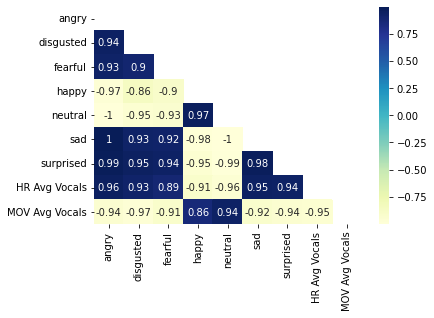

In [ ]:
mask = np.triu(np.ones_like(df_vocals.corr().corr()))
dataplot = sns.heatmap(df_vocals.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

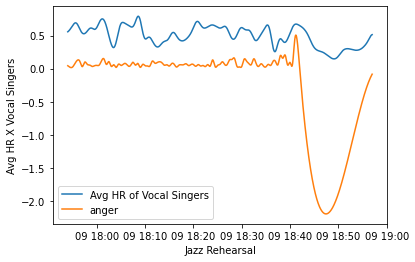

In [ ]:
sns.lineplot(x="timestamp", y="HR Avg Vocals", data=df_vocals, label='Avg HR of Vocal Singers')
sns.lineplot(x="timestamp", y="angry", data=df_vocals, label='anger')

plt.ylabel("Avg HR X Vocal Singers")
plt.xlabel("Jazz Rehearsal")
plt.show()

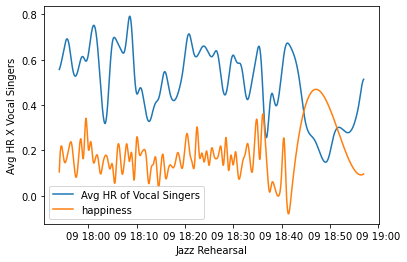

In [ ]:
sns.lineplot(x="timestamp", y="HR Avg Vocals", data=df_vocals, label='Avg HR of Vocal Singers')
sns.lineplot(x="timestamp", y="happy", data=df_vocals, label='happiness')

plt.ylabel("Avg HR X Vocal Singers")
plt.xlabel("Jazz Rehearsal")
plt.show()

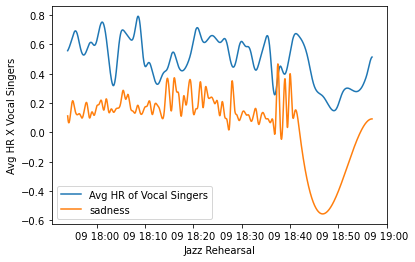

In [ ]:
sns.lineplot(x="timestamp", y="HR Avg Vocals", data=df_vocals, label='Avg HR of Vocal Singers')
sns.lineplot(x="timestamp", y="sad", data=df_vocals, label='sadness')

plt.ylabel("Avg HR X Vocal Singers")
plt.xlabel("Jazz Rehearsal")
plt.show()

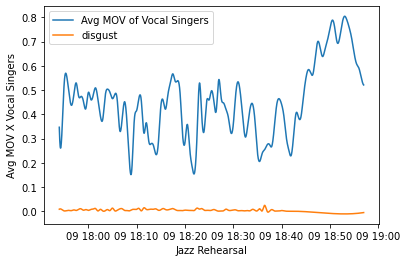

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Vocals", data=df_vocals, label='Avg MOV of Vocal Singers')
sns.lineplot(x="timestamp", y="disgusted", data=df_vocals, label='disgust')

plt.ylabel("Avg MOV X Vocal Singers")
plt.xlabel("Jazz Rehearsal")
plt.show()

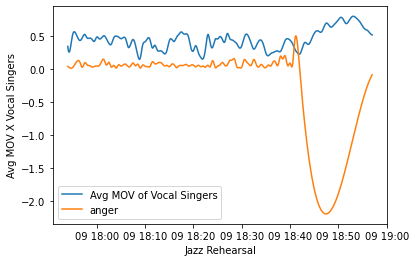

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Vocals", data=df_vocals, label='Avg MOV of Vocal Singers')
sns.lineplot(x="timestamp", y="angry", data=df_vocals, label='anger')

plt.ylabel("Avg MOV X Vocal Singers")
plt.xlabel("Jazz Rehearsal")
plt.show()

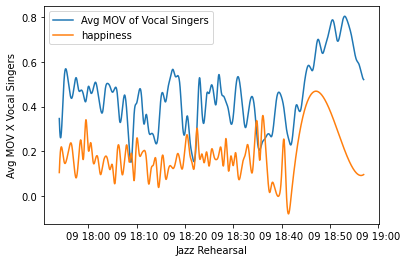

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Vocals", data=df_vocals, label='Avg MOV of Vocal Singers')
sns.lineplot(x="timestamp", y="happy", data=df_vocals, label='happiness')

plt.ylabel("Avg MOV X Vocal Singers")
plt.xlabel("Jazz Rehearsal")
plt.show()

Drum Players

In [ ]:
df_drums.corr()

,angry,disgusted,fearful,happy,neutral,sad,surprised,HR Avg Drums,MOV Avg Drums
angry,1.000000,0.614021,0.517028,-0.747968,-0.986064,0.910006,0.697746,0.158375,-0.103547
disgusted,0.614021,1.000000,0.490898,-0.191447,-0.664512,0.593651,0.677194,0.212494,-0.406338
fearful,0.517028,0.490898,1.000000,-0.320947,-0.545335,0.518903,0.581097,0.043762,-0.259845
happy,-0.747968,-0.191447,-0.320947,1.000000,0.661056,-0.647852,-0.383427,0.003471,-0.180313
neutral,-0.986064,-0.664512,-0.545335,0.661056,1.000000,-0.951609,-0.753442,-0.167031,0.182857
sad,0.910006,0.593651,0.518903,-0.647852,-0.951609,1.000000,0.745944,0.123506,-0.216768
surprised,0.697746,0.677194,0.581097,-0.383427,-0.753442,0.745944,1.000000,0.061395,-0.372901
HR Avg Drums,0.158375,0.212494,0.043762,0.003471,-0.167031,0.123506,0.061395,1.000000,0.152985
MOV Avg Drums,-0.103547,-0.406338,-0.259845,-0.180313,0.182857,-0.216768,-0.372901,0.152985,1.000000


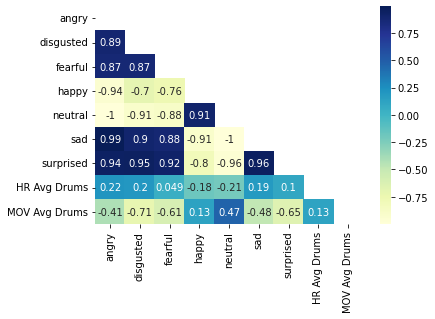

In [ ]:
mask = np.triu(np.ones_like(df_drums.corr().corr()))
dataplot = sns.heatmap(df_drums.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

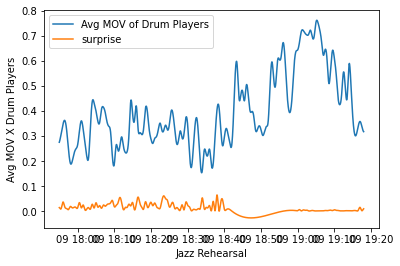

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Drums", data=df_drums, label='Avg MOV of Drum Players')
sns.lineplot(x="timestamp", y="surprised", data=df_drums, label='surprise')

plt.ylabel("Avg MOV X Drum Players")
plt.xlabel("Jazz Rehearsal")
plt.show()

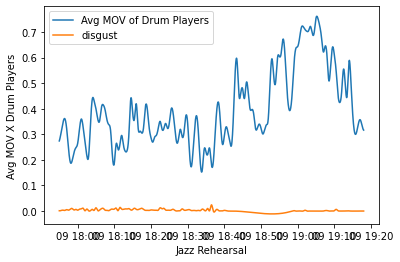

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Drums", data=df_drums, label='Avg MOV of Drum Players')
sns.lineplot(x="timestamp", y="disgusted", data=df_drums, label='disgust')

plt.ylabel("Avg MOV X Drum Players")
plt.xlabel("Jazz Rehearsal")
plt.show()

Saxophone

In [ ]:
df_saxophone.corr()

,angry,disgusted,fearful,happy,neutral,sad,surprised,HR Avg Sax,MOV Avg Sax
angry,1.000000,0.590142,0.474202,-0.731341,-0.984420,0.902285,0.678375,-0.262005,0.383663
disgusted,0.590142,1.000000,0.429603,-0.169455,-0.643653,0.578735,0.648838,-0.158675,0.357350
fearful,0.474202,0.429603,1.000000,-0.279354,-0.503533,0.474450,0.552499,-0.144968,0.220885
happy,-0.731341,-0.169455,-0.279354,1.000000,0.635001,-0.617105,-0.347490,0.193871,-0.229560
neutral,-0.984420,-0.643653,-0.503533,0.635001,1.000000,-0.948085,-0.738151,0.229557,-0.390970
sad,0.902285,0.578735,0.474450,-0.617105,-0.948085,1.000000,0.729778,-0.143609,0.362837
surprised,0.678375,0.648838,0.552499,-0.347490,-0.738151,0.729778,1.000000,-0.040829,0.262609
HR Avg Sax,-0.262005,-0.158675,-0.144968,0.193871,0.229557,-0.143609,-0.040829,1.000000,-0.482021
MOV Avg Sax,0.383663,0.357350,0.220885,-0.229560,-0.390970,0.362837,0.262609,-0.482021,1.000000


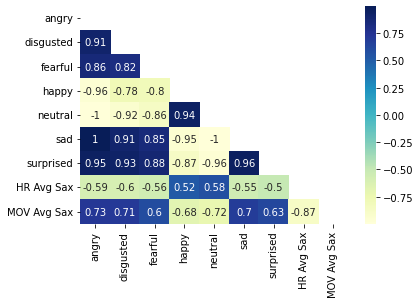

In [ ]:
mask = np.triu(np.ones_like(df_saxophone.corr().corr()))
dataplot = sns.heatmap(df_saxophone.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

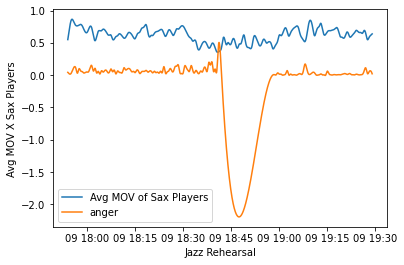

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Sax", data=df_saxophone, label='Avg MOV of Sax Players')
sns.lineplot(x="timestamp", y="angry", data=df_saxophone, label='anger')

plt.ylabel("Avg MOV X Sax Players")
plt.xlabel("Jazz Rehearsal")
plt.show()

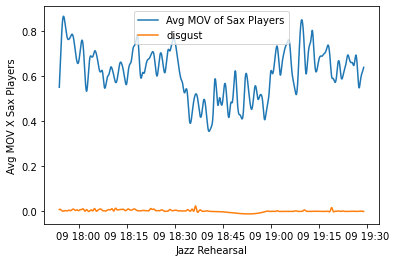

In [ ]:
sns.lineplot(x="timestamp", y="MOV Avg Sax", data=df_saxophone, label='Avg MOV of Sax Players')
sns.lineplot(x="timestamp", y="disgusted", data=df_saxophone, label='disgust')

plt.ylabel("Avg MOV X Sax Players")
plt.xlabel("Jazz Rehearsal")
plt.show()

Saxophone Stars

In [ ]:
df_sax_star.corr()

,angry,disgusted,fearful,happy,neutral,sad,surprised,HR Sax Stars,MOV Sax Stars
angry,1.000000,0.590142,0.474202,-0.731341,-0.984420,0.902285,0.678375,-0.118483,-0.221417
disgusted,0.590142,1.000000,0.429603,-0.169455,-0.643653,0.578735,0.648838,-0.030593,-0.392023
fearful,0.474202,0.429603,1.000000,-0.279354,-0.503533,0.474450,0.552499,-0.157551,0.031695
happy,-0.731341,-0.169455,-0.279354,1.000000,0.635001,-0.617105,-0.347490,0.153018,-0.072629
neutral,-0.984420,-0.643653,-0.503533,0.635001,1.000000,-0.948085,-0.738151,0.078391,0.238605
sad,0.902285,0.578735,0.474450,-0.617105,-0.948085,1.000000,0.729778,-0.005647,-0.147843
surprised,0.678375,0.648838,0.552499,-0.347490,-0.738151,0.729778,1.000000,0.007616,-0.155585
HR Sax Stars,-0.118483,-0.030593,-0.157551,0.153018,0.078391,-0.005647,0.007616,1.000000,-0.355232
MOV Sax Stars,-0.221417,-0.392023,0.031695,-0.072629,0.238605,-0.147843,-0.155585,-0.355232,1.000000


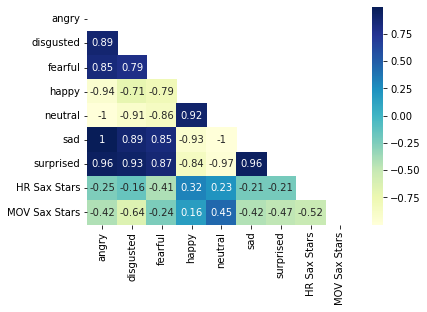

In [ ]:
mask = np.triu(np.ones_like(df_sax_star.corr().corr()))
dataplot = sns.heatmap(df_sax_star.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

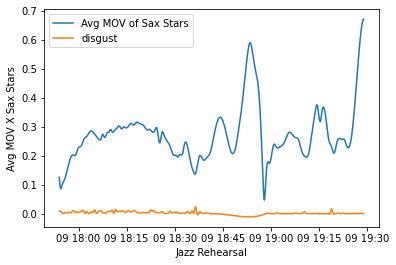

In [ ]:
sns.lineplot(x="timestamp", y="MOV Sax Stars", data=df_sax_star, label='Avg MOV of Sax Stars')
sns.lineplot(x="timestamp", y="disgusted", data=df_sax_star, label='disgust')

plt.ylabel("Avg MOV X Sax Stars")
plt.xlabel("Jazz Rehearsal")
plt.show()

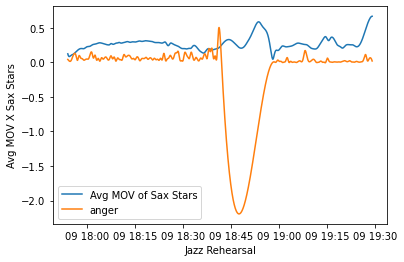

In [ ]:
sns.lineplot(x="timestamp", y="MOV Sax Stars", data=df_sax_star, label='Avg MOV of Sax Stars')
sns.lineplot(x="timestamp", y="angry", data=df_sax_star, label='anger')

plt.ylabel("Avg MOV X Sax Stars")
plt.xlabel("Jazz Rehearsal")
plt.show()

Audience

In [ ]:
df_audience.corr()

,angry,disgusted,fearful,happy,neutral,sad,surprised,HR Avg Audi,MOV Avg Audi
angry,1.000000,0.590142,0.474202,-0.731341,-0.984420,0.902285,0.678375,-0.241923,-0.026287
disgusted,0.590142,1.000000,0.429603,-0.169455,-0.643653,0.578735,0.648838,-0.187006,0.111233
fearful,0.474202,0.429603,1.000000,-0.279354,-0.503533,0.474450,0.552499,-0.061088,-0.068989
happy,-0.731341,-0.169455,-0.279354,1.000000,0.635001,-0.617105,-0.347490,0.103312,0.099393
neutral,-0.984420,-0.643653,-0.503533,0.635001,1.000000,-0.948085,-0.738151,0.249003,0.005889
sad,0.902285,0.578735,0.474450,-0.617105,-0.948085,1.000000,0.729778,-0.222580,0.003146
surprised,0.678375,0.648838,0.552499,-0.347490,-0.738151,0.729778,1.000000,-0.133478,0.014874
HR Avg Audi,-0.241923,-0.187006,-0.061088,0.103312,0.249003,-0.222580,-0.133478,1.000000,-0.141170
MOV Avg Audi,-0.026287,0.111233,-0.068989,0.099393,0.005889,0.003146,0.014874,-0.141170,1.000000


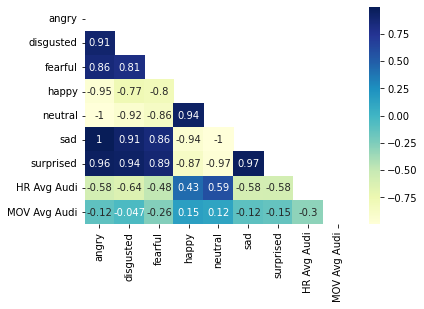

In [ ]:
mask = np.triu(np.ones_like(df_audience.corr().corr()))
dataplot = sns.heatmap(df_audience.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()